# Week 12.2.2  - Generating word embeddings using Gensim Word2Vec
## Word Embeddings and Word2Vec

![alt text](https://cdn.analyticsvidhya.com/wp-content/uploads/2017/06/06062705/Word-Vectors.png)

[analyticsvidhya](https://cdn.analyticsvidhya.com/wp-content/uploads/2017/06/06062705/Word-Vectors.png)

## Dataset

This notebook is based on the Kavita Ganesan's tutorial, 

http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/

with the dataset `reviews_data.txt.gz` available at: 

https://github.com/kavgan/data-science-tutorials/tree/master/word2vec

The dataset is a single text file concatenated from 259K full hote reviews from OpinRank. The full OpinRank dataset also has car reviews, which is available at the UCI Machine Learning Repository.

http://archive.ics.uci.edu/ml/datasets/opinrank+review+dataset

#### Hotel Reviews

- Full reviews of hotels in 10 different cities (Dubai, Beijing, London, New York City, New Delhi, San Francisco, Shanghai, Montreal, Las Vegas, Chicago) 
- There are about 80-700 hotels in each city 
- Extracted fields include date, review title and the full review 
- Total number of reviews: ~259,000

In [1]:
# Pip install all the requried packages
# !pip install gensim, bokeh, matplotlib, numpy, pandas
!pip install bokeh

In [0]:
# Import required packages and setup logging functionality
import gzip
import gensim 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#### Get access to Google Drive to permit access to data

In [3]:
# Mount google drive to notebook to access data.
# This will prompt you to enter an authentication code by permitting access to the drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
# The data_file path will be different depending on where you've copied the notebooks...
data_file='/content/drive/My Drive/12-text-processing/data/reviews_data.txt.gz'

with gzip.open(data_file, 'rb') as f:
    for i,line in enumerate(f):
        print(line)
        break

b"Oct 12 2009 \tNice trendy hotel location not too bad.\tI stayed in this hotel for one night. As this is a fairly new place some of the taxi drivers did not know where it was and/or did not want to drive there. Once I have eventually arrived at the hotel, I was very pleasantly surprised with the decor of the lobby/ground floor area. It was very stylish and modern. I found the reception's staff geeting me with 'Aloha' a bit out of place, but I guess they are briefed to say that to keep up the coroporate image.As I have a Starwood Preferred Guest member, I was given a small gift upon-check in. It was only a couple of fridge magnets in a gift box, but nevertheless a nice gesture.My room was nice and roomy, there are tea and coffee facilities in each room and you get two complimentary bottles of water plus some toiletries by 'bliss'.The location is not great. It is at the last metro stop and you then need to take a taxi, but if you are not planning on going to see the historic sites in Be

### Read hotel reviews data

The original format of the hotel review data is in .zip which is composed of numerous .json data files, these are read into memory in iteratively. Furthermore, a gensim utility function `gensim.utils.simple_preprocess()` is used to pre-process the text as it's read.

`simple_preprocess()` converts a document (in this case a review) into a list of tokens that are lower cased.

In [7]:
def read_input(input_file):
    """This method reads the input file which is in gzip format"""
    
    logging.info("reading file {0}...this may take a while".format(input_file))
    
    with gzip.open(input_file, 'rb') as f:
        for i, line in enumerate(f): 

            if (i%50000==0):
                logging.info("read {0} reviews".format(i))
            # Do some pre-processing and return a list of words for each review text
            # 
            yield gensim.utils.simple_preprocess(line)

# read the tokenized reviews into a list
# each review item becomes a series of words
# so this becomes a list of lists
documents = list(read_input(data_file))
logging.info("Done reading data file")

2020-03-25 05:55:11,499 : INFO : reading file /content/drive/My Drive/12-text-processing/data/reviews_data.txt.gz...this may take a while
2020-03-25 05:55:11,504 : INFO : read 0 reviews
2020-03-25 05:55:22,367 : INFO : read 50000 reviews
2020-03-25 05:55:32,225 : INFO : read 100000 reviews
2020-03-25 05:55:41,236 : INFO : read 150000 reviews
2020-03-25 05:55:51,271 : INFO : read 200000 reviews
2020-03-25 05:56:00,576 : INFO : read 250000 reviews
2020-03-25 05:56:01,567 : INFO : Done reading data file


## Understanding some of the parameters

To train the model earlier, we had to set some parameters. Now, let's try to understand what some of them mean. For reference, this is the command that we used to train the model:
`model = gensim.models.Word2Vec (documents, size=150, window=10, min_count=2, workers=10)`

#### Parameters of Interest
`size`<br>
The size of the dense vector to represent each token or word. If you have very limited data, then size should be a much smaller value. If you have lots of data, its good to experiment with various sizes. Typical sizes are 100-300. A value of 100-150 has worked well for me. 

`window`<br>
The maximum distance between the target word and its neighboring word. If your neighbor's position is greater than the maximum window width to the left and the right, then, some neighbors are not considered as being related to the target word. In theory, a smaller window should give you terms that are more related. If you have lots of data, then the window size should not matter too much, as long as its a decent sized window.

`min_count`<br>
Minimium frequency count of words. The model would ignore words that do not statisfy the min_count. Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model.

`workers`<br>
How many threads to use behind the scenes?

In [8]:
%timeit
model = gensim.models.Word2Vec(documents, size=150, window=10, min_count=2, workers=10)
model.train(documents,total_examples=len(documents),epochs=10)

2020-03-25 05:56:02,466 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2020-03-25 05:56:02,469 : INFO : collecting all words and their counts
2020-03-25 05:56:02,475 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-03-25 05:56:02,808 : INFO : PROGRESS: at sentence #10000, processed 1655714 words, keeping 25777 word types
2020-03-25 05:56:03,184 : INFO : PROGRESS: at sentence #20000, processed 3317863 words, keeping 35016 word types
2020-03-25 05:56:03,581 : INFO : PROGRESS: at sentence #30000, processed 5264072 words, keeping 47518 word types
2020-03-25 05:56:03,939 : INFO : PROGRESS: at sentence #40000, processed 7081746 words, keeping 56675 word types
2020-03-25 05:56:04,334 : INFO : PROGRESS: at sentence #50000, processed 9089491 words, keeping 63744 word types
2020-03-25 05:56:04,715 : INFO : PROGRESS: at sentence #60000, processed 11013723 words, keeping 76781 word types
2020-03-25 05:56:05,043 : INFO : PROGRESS: a

(303496489, 415193550)

# Looking at outputs
- How are common words representated as vectors?
- Can we find similarities between words?

### Words represented as vectors

In [9]:
# Get vector representation of a word
testWord = 'dirty'
print(f'Word - {testWord}\nVector Representation\n{model.wv.get_vector(testWord)}')
print(f'Shape of vector: {model.wv.get_vector(testWord).shape[0]}')

Word - dirty
Vector Representation
[ 1.2900537e-01  4.2360061e-01 -2.2724199e+00  2.6745987e+00
  1.3271627e+00 -4.9147811e+00  1.6811494e+00 -7.1777141e-01
 -2.1335958e-01  5.7499778e-01  9.5894253e-01 -2.2711265e+00
  3.2498796e+00  2.6368549e+00 -1.5409565e+00 -2.8649371e+00
  3.3361034e+00  2.2617354e+00 -9.7138333e-01 -2.9344118e+00
 -8.1759608e-01 -5.6736612e-01 -1.8994638e+00  2.5589683e+00
  1.3636303e+00 -4.2929206e+00  1.7215750e+00  1.3490070e+00
 -1.4974842e+00 -1.5161125e-01 -3.4537423e+00 -7.2080499e-01
 -3.5484124e-02 -4.4826027e-03 -1.5903081e+00  3.0588610e+00
  7.5869173e-01  4.0026159e+00 -1.8979703e+00  2.4265215e+00
 -4.8891621e+00  2.0318277e+00  2.9359603e+00  3.1996434e+00
 -7.2777313e-01 -4.0270805e+00  1.8581769e+00 -1.9446160e+00
 -4.0844545e-01  9.9635291e-01 -2.3741388e+00  3.6934383e+00
  1.9942520e+00 -3.0028129e+00 -2.8652141e+00 -1.0470130e+00
 -3.9433620e+00  2.2372622e+00  1.7946882e+00 -5.2673197e-01
  4.8544660e-01  3.9126661e+00  3.9783254e+00  1.6

### Finding similarities between words

In [10]:
w1 = "dirty"
model.wv.most_similar(positive=w1)

2020-03-25 06:17:43,364 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('filthy', 0.86473149061203),
 ('unclean', 0.7755036950111389),
 ('dusty', 0.7688254117965698),
 ('stained', 0.7665022015571594),
 ('grubby', 0.7511715888977051),
 ('smelly', 0.7417137622833252),
 ('dingy', 0.7327624559402466),
 ('gross', 0.7249294519424438),
 ('disgusting', 0.7203068137168884),
 ('soiled', 0.7099473476409912)]

In [11]:
# look up top 6 words similar to 'polite'
w1 = ["polite"]
model.wv.most_similar(positive=w1,topn=6)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('courteous', 0.9184607267379761),
 ('friendly', 0.8230020403862),
 ('cordial', 0.7993004322052002),
 ('professional', 0.7940875887870789),
 ('attentive', 0.7878902554512024),
 ('curteous', 0.7727060914039612)]

In [12]:
# look up top 6 words similar to 'france'
w1 = ["france"]
model.wv.most_similar(positive=w1,topn=6)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('germany', 0.6896160840988159),
 ('canada', 0.6771130561828613),
 ('spain', 0.6380112767219543),
 ('lisbon', 0.6203307509422302),
 ('austria', 0.6161412000656128),
 ('rome', 0.6133030652999878)]

In [13]:
# look up top 6 words similar to 'shocked'
w1 = ["shocked"]
model.wv.most_similar(positive=w1,topn=6)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('horrified', 0.8186733722686768),
 ('amazed', 0.7841743230819702),
 ('dismayed', 0.782692015171051),
 ('astonished', 0.7670125365257263),
 ('appalled', 0.7650678753852844),
 ('stunned', 0.7523097395896912)]

In [14]:
# Get everything related to stuff on the bed
w1 = ['bed','sheet','pillow']
w2 = ['couch']
model.wv.most_similar(positive=w1,negative=w2,topn=10)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('duvet', 0.7167590856552124),
 ('blanket', 0.7083277106285095),
 ('quilt', 0.7026077508926392),
 ('mattress', 0.694766640663147),
 ('matress', 0.6944983601570129),
 ('pillowcase', 0.6720463633537292),
 ('sheets', 0.6483705639839172),
 ('pillows', 0.6390425562858582),
 ('foam', 0.6327984929084778),
 ('comforter', 0.619051456451416)]

In [15]:
# Similarity between two different words
print(f'Similarity between the words dirty and smelly: {model.wv.similarity(w1="dirty",w2="smelly"):0.3}')

Similarity between the words dirty and smelly: 0.742


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [16]:
# Similarity between two identical words
print(f'Similarity between the same word dirty: {model.wv.similarity(w1="dirty",w2="dirty"):0.3}')

Similarity between the same word dirty: 1.0


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [17]:
# similarity between two unrelated words
print(f'Similarity between the words dirty and clean: {model.wv.similarity(w1="dirty",w2="clean"):0.3}')

Similarity between the words dirty and clean: 0.265


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [18]:
# Which one is the odd one out in this list?
oddOneOutList = ["cat", "dog", "france"]
print(f'Which words doesnt belong in the set [cat, dog, france]? Odd one out: {model.wv.doesnt_match(oddOneOutList)}')

Which words doesnt belong in the set [cat, dog, france]? Odd one out: france


/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [19]:
# Which one is the odd one out in this list?
oddOneOutList = ["bed","pillow","duvet","shower"]
print(f'Which words doesnt belong in the set [bed, pillow, duvet, shower]? Odd one out: {model.wv.doesnt_match(oddOneOutList)}')

Which words doesnt belong in the set [bed, pillow, duvet, shower]? Odd one out: shower


/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


## Visualising the word vectors in 2D space

Here we use a dimensionality reduction and visualisation package from Scikit-Learn, t-Distributed Stochastic Neighbor Embedding (t-SNE), which is particularly suited for visualising high dimensional data. Another popular options for dimensionality reduction is Principal Component Analysis (PCA).

Note: the dimension of our word vectors by choice is 150, typical numbers could be 50, 100, and 300. Among these numbers, a dimension of 300 has been shown as most effective in capturing the syntatic and semantic information of a word. However, it will take much longer to train. 

In [0]:
# Load required statistical package
from sklearn.manifold import TSNE

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# Need the interactive Tools for Matplotlib
%matplotlib inline
# Plot formatting
plt.rcParams["figure.figsize"] = [16,9]
font = {'size':16}
matplotlib.rc('font', **font)

In [0]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,150), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.title(f'Words closest to: {word}')
    plt.show()

### Visualising closest words in 2D

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


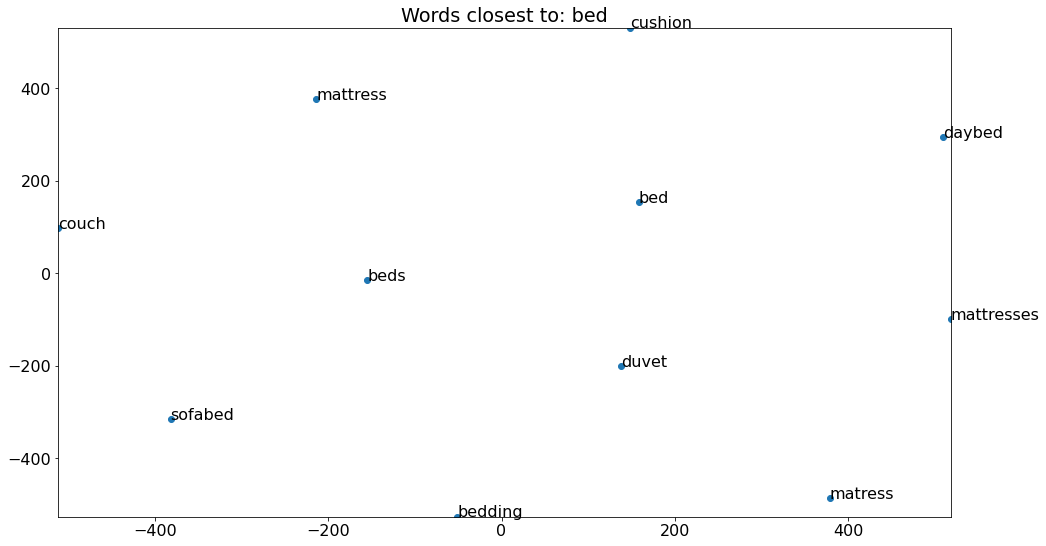

In [22]:
display_closestwords_tsnescatterplot(model.wv, "bed")

# Generating word embeddings for domain-specific inforamtion
Word embeddings are interesting and thought provoking but
- What insights can we gain from them?
- How do we apply them to industry data?

This section of the notebook will explore word embeddings and their application to geological survey data (GSWA).

## Loading a small sample of Geological Survey of Western Australia (GSWA) data
Note: we have already added our Google Drive to the notebook, so we don't need to do this again.

In [0]:
import zipfile
import json

In [0]:
data_file="/content/drive/My Drive/12-text-processing/data/wamex_xml.zip"

In [27]:
# Import Dataset
data = list()
with zipfile.ZipFile(data_file, "r") as z:
    #df = [pd.read_json(filename) for filename in z.namelist()]
    print(len(z.namelist()))
    for filename in z.namelist():
        # print(filename)
        # df = pd.read_json(filename)
        with z.open(filename) as f:
            # load the json file
            # The resulting `content` is a list
            content = json.loads(f.read()) 
            # Convert content to a string   
            content = "".join(content)
            # Add to the data list
            data.append(content)

1135


In [28]:
# Previewing the data that we have loaded. This is very different to the hotel reviews dataset.
pprint(data[:1])

Pretty printing has been turned OFF


In [0]:
def read_input(input_file):
    """This method reads the input file which is in zip format"""
    
    logging.info("reading file {0}...this may take a while".format(input_file))

    data = list()
    with zipfile.ZipFile(input_file, "r") as z:
    #df = [pd.read_json(filename) for filename in z.namelist()]
        print(len(z.namelist()))
        for i, filename in enumerate(z.namelist()):
            # print(filename)
            # df = pd.read_json(filename)
            if (i%100==0):
                logging.info ("read {0} reports".format (i))
            with z.open(filename) as f:
                # load the json file
                # The resulting `content` is a list
                content = json.loads(f.read()) 
                # Convert content to a string   
                content = "".join(content)
                if len(content) >= 10:
                    # Add to the data list
                    yield gensim.utils.simple_preprocess (content)
                else:
                    logging.info("removed {0} because of small size".format (filename))

In [30]:
# read the tokenized reviews into a list
# each review item becomes a series of words
# so this becomes a list of lists
documents = list(read_input (data_file))
logging.info("Done reading data file")

2020-03-25 06:45:25,314 : INFO : reading file /content/drive/My Drive/12-text-processing/data/wamex_xml.zip...this may take a while
2020-03-25 06:45:25,334 : INFO : read 0 reports
2020-03-25 06:45:25,337 : INFO : removed a073351_a73351_16166749.json because of small size
2020-03-25 06:45:25,354 : INFO : removed a071095_a71095_14949032.json because of small size
2020-03-25 06:45:25,355 : INFO : removed a071096_a71096_14966153.json because of small size
2020-03-25 06:45:25,369 : INFO : removed a71566_a71566.json because of small size
2020-03-25 06:45:25,370 : INFO : removed a071595_a71595_16384226.json because of small size
2020-03-25 06:45:25,372 : INFO : removed a071598_a71598_16486759.json because of small size
2020-03-25 06:45:25,381 : INFO : removed a071627_a71627_16546786.json because of small size
2020-03-25 06:45:25,386 : INFO : removed a071641_verification lis tnw area 2005_16770850.json because of small size
2020-03-25 06:45:25,387 : INFO : removed a071642_a71642_16670806.json 

1135


2020-03-25 06:45:25,499 : INFO : removed a071801_a71801_15143983.json because of small size
2020-03-25 06:45:25,501 : INFO : removed a071801_a71801_17018831.json because of small size
2020-03-25 06:45:25,502 : INFO : removed a071808_a71808_15913542.json because of small size
2020-03-25 06:45:25,503 : INFO : removed a071811_a71811_15868928.json because of small size
2020-03-25 06:45:25,536 : INFO : removed a071847_m04_161162 location plan_17599975.json because of small size
2020-03-25 06:45:25,538 : INFO : removed a071849_esp_305_002b_12512962.json because of small size
2020-03-25 06:45:25,555 : INFO : removed a071854_a71854_16039280.json because of small size
2020-03-25 06:45:25,556 : INFO : removed a071860_intermingeol codes_15840037.json because of small size
2020-03-25 06:45:25,564 : INFO : removed a071864_a71864_16040327.json because of small size
2020-03-25 06:45:25,591 : INFO : removed a071876_doir_vlist_mayfield_annrpt_mar05_17328942.json because of small size
2020-03-25 06:45:2

In [31]:
# Review the first documents top 25 words. See how they have been pre-processed and tokenized.
pprint(documents[0][:25])

Pretty printing has been turned ON


### Training word embedding model off of domain-specific text.

Note: we are required to use bigrams to aid our model due to domain-specific terms.

In [0]:
import nltk

In [33]:
%timeit
phrases = gensim.models.Phrases(documents, min_count=1, threshold=1)
bigrams = gensim.models.phrases.Phraser(phrases)

# Note: we're referring to the model as DS (domain-specific). This allows us
# to make a contrast between the pretrained word embeddings and the domain-specific ones. 
modelDS = gensim.models.Word2Vec (bigrams[documents], size=50, window=10, min_count=2, workers=12)
modelDS.train(bigrams[documents],total_examples=len(documents),epochs=10)

2020-03-25 06:45:33,528 : INFO : collecting all words and their counts
2020-03-25 06:45:33,529 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-03-25 06:45:38,037 : INFO : collected 606238 word types from a corpus of 2745037 words (unigram + bigrams) and 858 sentences
2020-03-25 06:45:38,041 : INFO : using 606238 counts as vocab in Phrases<0 vocab, min_count=1, threshold=1, max_vocab_size=40000000>
2020-03-25 06:45:38,042 : INFO : source_vocab length 606238
2020-03-25 06:45:39,426 : INFO : Phraser added 50000 phrasegrams
2020-03-25 06:45:41,095 : INFO : Phraser added 100000 phrasegrams
2020-03-25 06:45:43,647 : INFO : Phraser added 150000 phrasegrams
2020-03-25 06:45:43,673 : INFO : Phraser built with 150170 phrasegrams
2020-03-25 06:45:43,674 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2020-03-25 06:45:43,677 : INFO : collecting all words and their counts
2020-03-25 06:45:43,680 : INFO : PROGRESS: at sentence #0, process

(12780802, 17556090)

## Looking at domain-specific outputs

In [34]:
print(list(model.wv.vocab.keys())[:1000])

['oct', 'nice', 'trendy', 'hotel', 'location', 'not', 'too', 'bad', 'stayed', 'in', 'this', 'for', 'one', 'night', 'as', 'is', 'fairly', 'new', 'place', 'some', 'of', 'the', 'taxi', 'drivers', 'did', 'know', 'where', 'it', 'was', 'and', 'or', 'want', 'to', 'drive', 'there', 'once', 'have', 'eventually', 'arrived', 'at', 'very', 'pleasantly', 'surprised', 'with', 'decor', 'lobby', 'ground', 'floor', 'area', 'stylish', 'modern', 'found', 'reception', 'staff', 'geeting', 'me', 'aloha', 'bit', 'out', 'but', 'guess', 'they', 'are', 'briefed', 'say', 'that', 'keep', 'up', 'coroporate', 'image', 'starwood', 'preferred', 'guest', 'member', 'given', 'small', 'gift', 'upon', 'check', 'only', 'couple', 'fridge', 'magnets', 'box', 'nevertheless', 'gesture', 'my', 'room', 'roomy', 'tea', 'coffee', 'facilities', 'each', 'you', 'get', 'two', 'complimentary', 'bottles', 'water', 'plus', 'toiletries', 'by', 'bliss', 'great', 'last', 'metro', 'stop', 'then', 'need', 'take', 'if', 'planning', 'on', 'goin

In [35]:
print(modelDS.wv['gold'])

[  7.716472     2.6746821    1.2795844   -3.7496536    4.0709844
  -8.680757    -8.142781    -8.901536     2.1908321    2.817838
   6.0053716   -6.0465155   -6.1741858    2.7444713   -7.9608808
  -0.06230826   0.43777415   0.58016825   3.0992205    5.552071
   3.5453818   -0.16158924   5.522284    -3.7859402   -3.7728996
   6.0902386   10.210878    -2.7974832   -3.2663774   -3.2828014
   6.1208186   -1.026301    -7.2423153   -3.7028935   -6.82419
  -0.8154362   -2.2235231    7.6038256  -11.217253    -0.51701546
   3.8103292    1.4871871   -0.5900511  -10.143343     7.5521717
  -2.7074351    4.001394    -3.7595294   -4.379172     4.883977  ]


In [36]:
w1 = "gold"
modelDS.wv.most_similar(positive=w1)

2020-03-25 06:48:28,000 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('nickel', 0.8354708552360535),
 ('copper', 0.7970185875892639),
 ('lead', 0.7674073576927185),
 ('au', 0.7265792489051819),
 ('discovered_at', 0.655239462852478),
 ('grading_au', 0.6526600122451782),
 ('significant_gold', 0.6524581909179688),
 ('silver', 0.6496130228042603),
 ('historically', 0.648182213306427),
 ('historic_gold', 0.6460644602775574)]

In [37]:
# look up top 6 words similar to 'polite'
w1 = ["iron"]
modelDS.wv.most_similar(positive=w1,topn=6)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('fe', 0.8044437766075134),
 ('sulphur', 0.7929227352142334),
 ('cobalt', 0.7887586951255798),
 ('uranium_nickel', 0.7729154825210571),
 ('manganese', 0.7697843313217163),
 ('hematite', 0.7680107951164246)]

In [38]:
# get everything related to stuff on the commodity
w1 = ["gold",'commodity','ore']
w2 = ['rock']
modelDS.wv.most_similar(positive=w1,negative=w2,topn=10)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('oz', 0.8222800493240356),
 ('of_million', 0.8160642981529236),
 ('ounces', 0.7903285622596741),
 ('of_tonnes', 0.7783627510070801),
 ('tonnes_at', 0.7644194960594177),
 ('mineral_inventory', 0.7537013292312622),
 ('mt_at', 0.7532788515090942),
 ('ore_reserve', 0.7531589269638062),
 ('production_from', 0.7521912455558777),
 ('production', 0.7499291896820068)]

In [39]:
# similarity between two different words
modelDS.wv.similarity(w1="gold",w2="ore")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.4328069

In [40]:
# similarity between two identical words
modelDS.wv.similarity(w1="gold",w2="gold")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


1.0

In [41]:
# similarity between two unrelated words
modelDS.wv.similarity(w1="gold",w2="rock")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


-0.12384071

In [42]:
# Which one is the odd one out in this list?
modelDS.wv.doesnt_match(["gold","rock","copper"])

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'rock'

### Comparing our domain-specific embeddings with embeddings trained on a different dataset (news articles).
- What are the nearest terms to 'commodity', 'ore', 'rock', etc.

Unfortunately due to the size of pretrained word embedding models they have been omitted from this comparison. However, the code below shows how to load the Google news word2vec embedding model. This model is trained on 100 billion words and is 1.6GB in size (massive!).

In [0]:
# Load Google's pre-trained Word2Vec model.
# 1.6GB trained over 100B words; dimension of 300. Cannot use in this notebook due to massive size and time required to load.

#import gensim.downloader as api
#wv = api.load('word2vec-google-news-300')   

In [0]:
# Define function to compare top-n similariries for a given word between two embedding models.
def compare_words(word, topn, model1, model2):
  similarWordsModel1 = model1.wv.most_similar(positive=word, topn=topn)
  similarWordsModel2 = model2.wv.most_similar(positive=word,topn=topn)

  print(f'Top {topn} words similar to {word}\n(format: n|model 1|model 2)\n')
  for n in range(topn):
    print(f'{n+1} |{similarWordsModel1[n][0]} | {similarWordsModel2[n][0]}')

In [45]:
# Looking at the word 'commodity'
compare_words('commodity', 5, model1=model, model2=modelDS)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Top 5 words similar to commodity
(format: n|model 1|model 2)

1 |nowadays | feasibility
2 |rarity | hardcore_geological
3 |additoinal | states_that
4 |obsession | of_goldfan
5 |uncommon | nl_asx


In [46]:
# Looking at the word 'ore'
compare_words('ore', 5, model1=model, model2=modelDS)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Top 5 words similar to ore
(format: n|model 1|model 2)

1 |tre | oz
2 |chouette | gold_price
3 |beaucoup | million_tonnes
4 |vive | grade
5 |klein | mined


In [47]:
# Looking at the word 'rock'
compare_words('rock', 5, model1=model, model2=modelDS)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Top 5 words similar to rock
(format: n|model 1|model 2)

1 |rocks | lamproite
2 |rosey | fine_grained
3 |carnation | composition
4 |boiled | phenocrysts_plagioclase
5 |snapper | hand_specimen


### Visualising the domain-specific word vectors in 2D space

In [0]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,50), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.title(f'Words closest to: {word}')
    plt.show()


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


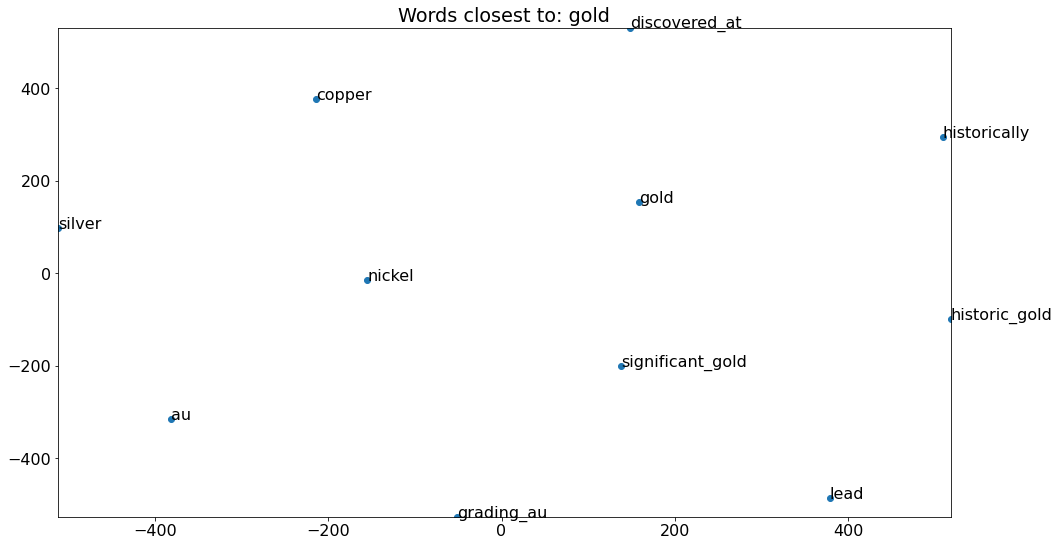

In [49]:
display_closestwords_tsnescatterplot(modelDS.wv, "gold")

#### Visualising all of the words in the vocabulary

In [50]:
tsne = TSNE(n_components=2)
print(type(modelDS.wv.vocab))
X = modelDS[modelDS.wv.vocab]

<class 'dict'>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
# Shape of our model before t-SNE
X.shape

(118244, 50)

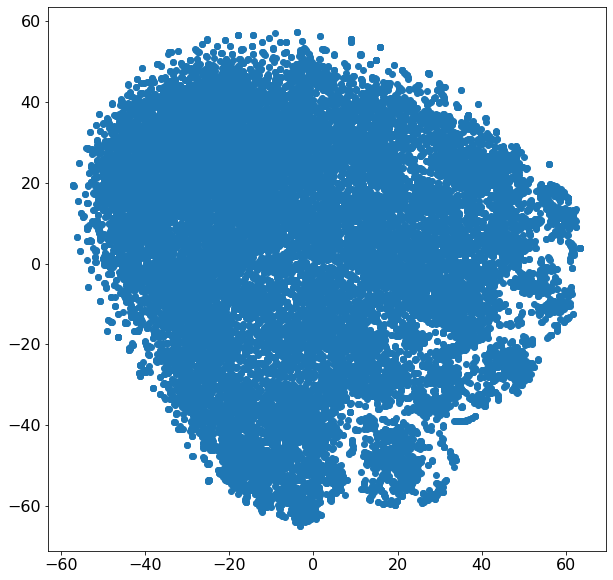

In [53]:
%timeit
# Fitting subset of data to t-SNE
X_limited = X[:25000]
X_tsne = tsne.fit_transform(X_limited)

# Uncomment line below to fit entire model to t-SNE
# X_tsne = tsne.fit_transform(X)

plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

#### Interactive Visualisation

Refer to https://www.datascience.com/resources/notebooks/word-embeddings-in-python, and also for ideas of incoporating POS and bigrams into word2vec training.

In [0]:
from bokeh.plotting import figure, show
from bokeh.io import push_notebook, output_notebook
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show
from bokeh.io import push_notebook, output_notebook
from bokeh.models import ColumnDataSource, LabelSet
import pandas as pd

In [0]:
def interactive_tsne(text_labels, tsne_array):
    '''makes an interactive scatter plot with text labels for each point'''

    # define a dataframe to be used by bokeh context
    bokeh_df = pd.DataFrame(tsne_array, text_labels, columns=['x','y'])
    bokeh_df['text_labels'] = bokeh_df.index

    # interactive controls to include to the plot
    TOOLS="hover, zoom_in, zoom_out, box_zoom, undo, redo, reset, box_select"

    p = figure(tools=TOOLS, plot_width=700, plot_height=700)

    # define data source for the plot
    source = ColumnDataSource(bokeh_df)

    # scatter plot
    p.scatter('x', 'y', source=source, fill_alpha=0.6,
              fill_color="#8724B5",
              line_color=None)

    # text labels
    labels = LabelSet(x='x', y='y', text='text_labels', y_offset=8,
                      text_font_size="8pt", text_color="#555555",
                      source=source, text_align='center')

    p.add_layout(labels)

    # show plot inline
    output_notebook()
    show(p)

In [0]:
interactive_tsne(modelDS.wv.vocab.keys(), X_tsne)